# Wind Farm Simulation

In this example, a simple wind farm case is presented where the different capabilities of PyWake such as calculating AEP, extracting power values and plotting time series are shown.

**Install PyWake if needed**

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

**First we import some basic Python elements**

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

**Now we import the site, wind turbine and wake deficit model to use in the simulation**

In [29]:
# import and setup site and windTurbines
%reload_ext py_wake.utils.notebook_extensions

from tqdm.notebook import tqdm
from py_wake.utils import layouts
from py_wake.utils.profiling import timeit, profileit
from py_wake.examples.data.hornsrev1 import Hornsrev1Site, V80
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
from py_wake.utils.plotting import setup_plot
xr.set_options(display_expand_data=False)

site = Hornsrev1Site()
x, y = site.initial_position.T
windTurbines = V80()

wf_model = Bastankhah_PorteAgel_2014(site, windTurbines, k=0.0324555)

#this allows you to see what type of engineering models you are simulating
print(wf_model)

Bastankhah_PorteAgel_2014(PropagateDownwind, BastankhahGaussianDeficit-wake, LinearSum-superposition)


## Simple simulation - all wind directions and wind speeds

To run the wind farm simulation, we must call the `WindFarmModel` (wf_model) element that was previously created. As default, the model will run for all wind directions and wind speeds defined. The default properties are:

- `site.default_wd`: 0-360$^\circ$ in bins of 1$^\circ$
- `site.default_ws`: 3-25 m/s in bins of 1 m/s

The default values for wind speeds and wind directions can be overwritten by either a scalar or an array.

In [30]:
sim_res = wf_model(x, y,     # wind turbine positions
                   h=None,   # wind turbine heights (defaults to the heights defined in windTurbines)
                   type=0,   # Wind turbine types
                   wd=None,  # Wind direction
                   ws=None,  # Wind speed
                  )

## Simulation Results

The `SimulationResult` object is a xarray dataset that provides information about the simulation result with some additional methods and attributes. 
It has the coordinates

- `wt`: Wind turbine number
- `wd`: Ambient reference wind direction
- `ws`: Ambient reference wind speed
- `x`,`y`,`h`: position and hub height of wind turbines

and data variables:

- `WD`: Local free-stream wind direction
- `WS`: Local free-stream wind speed
- `TI`: Local free-stream turbulence intensity
- `P`: Probability of flow case (wind direction and wind speed)
- `WS_eff`: Effetive local wind speed [m/s]
- `TI_eff`: Effective local turbulence intensity
- `power`: Effective power production [W]
- `ct`: Thrust coefficient
- `Yaw`: Yaw misalignment [deg]

where "effective" means "including wake effects"
 

In [31]:
#printing the simulation result from the wake model previously defined
sim_res

<xarray.SimulationResult> Size: 21MB
Dimensions:           (wt: 80, wd: 360, ws: 23)
Coordinates:
  * ws                (ws) int64 184B 3 4 5 6 7 8 9 10 ... 19 20 21 22 23 24 25
  * wd                (wd) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
  * wt                (wt) int64 640B 0 1 2 3 4 5 6 7 ... 73 74 75 76 77 78 79
    type              (wt) float64 640B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Data variables: (12/17)
    WS_eff            (wt, wd, ws) float64 5MB 3.0 4.0 5.0 ... 22.84 23.86 24.87
    TI_eff            (wt, wd, ws) float64 5MB 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1
    Power             (wt, wd, ws) float64 5MB 0.0 6.66e+04 ... 2e+06 2e+06
    CT                (wt, wd, ws) float64 5MB 0.0 0.818 ... 0.06101 0.05393
    h                 (wt) float64 640B 70.0 70.0 70.0 70.0 ... 70.0 70.0 70.0
    x                 (wt) int64 640B 423974 424042 424111 ... 429424 429492
    ...                ...
    ws_l              (ws) float64 184B 2.5 3.5 4.5 5.5 ... 21.5 22.5 23.5 24.5
    ws_u              (ws) float64 184B 3.5 4.5 5.5 6.5 ... 22.5 23.5 24.5 25.5
    Weibull_A         (wd) float64 3kB 9.177 9.177 9.177 ... 9.177 9.177 9.177
    Weibull_k         (wd) float64 3kB 2.393 2.393 2.393 ... 2.393 2.393 2.393
    Sector_frequency  (wd) float64 3kB 0.001199 0.001199 ... 0.001199 0.001199
    P                 (wd, ws) float64 66kB 6.147e-05 8.559e-05 ... 2.193e-08

#### Selecting data

Data can be selected using the xarray `sel` method.

For example, the power production of wind turbine 3 when the wind is coming from the East (90deg) for all wind speeds bins:

In [32]:
sim_res.Power.sel(wt=3, wd=0)

<xarray.DataArray 'Power' (ws: 23)> Size: 184B
0.0 5.459e+04 1.293e+05 2.39e+05 3.902e+05 ... 2e+06 2e+06 2e+06 2e+06 2e+06
Coordinates:
  * ws       (ws) int64 184B 3 4 5 6 7 8 9 10 11 ... 17 18 19 20 21 22 23 24 25
    wd       int64 8B 0
    wt       int64 8B 3
    type     float64 8B 0.0
Attributes:
    Description:  Power [W]

We can also get the total power of turbine 3 for the wind direction specified.

In [35]:
total_power = sim_res.Power.sel(wt=3, wd=0).sum().values/1e6
print('Total power: %f MW'%total_power)

Total power: 32.513680 MW


#### Plotting data

Data can be plotted using the xarray `plot` method.

For example, the power production of wind turbine 35 as a function of wind direction and wind speed.

Text(0.5, 0, 'x [m]')

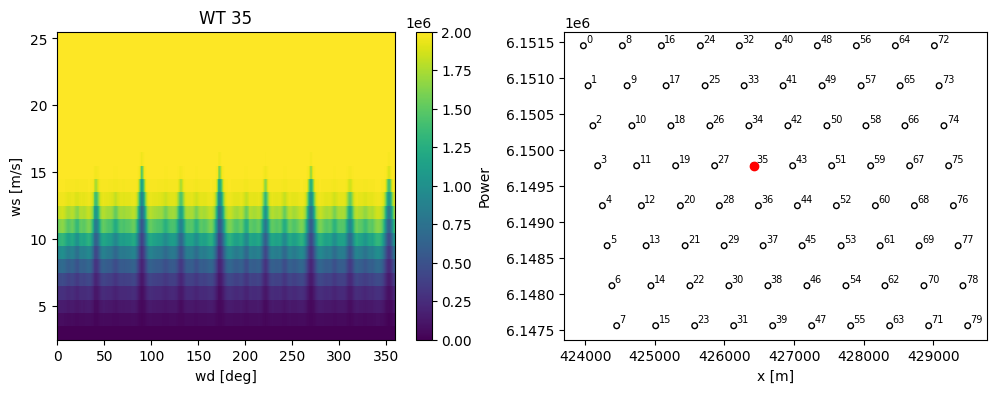

In [36]:
ax1, ax2 = plt.subplots(1,2, figsize=(12,4))[1]
sim_res.Power.sel(wt=35).T.plot(ax=ax1)
ax1.set_xlabel('wd [deg]')
ax1.set_ylabel('ws [m/s]')
ax1.set_title('WT 35')
windTurbines.plot(x,y, ax=ax2)
ax2.plot(x[35],y[35],'or')
ax2.set_xlabel('x [m]')

#### AEP calculation

Furthermore, `SimulationResult`, contains the method `aep` that calculates the Annual Energy Production. This can be done for all of the turbines as well as the total AEP of the wind farm, in GWh.

Here we can obtain the AEP of wind turbine 80 for all wind speed and wind directions:

In [37]:
sim_res.aep()

<xarray.DataArray 'AEP [GWh]' (wt: 80, wd: 360, ws: 23)> Size: 5MB
0.0 4.993e-05 0.0001429 0.0002968 ... 5.757e-06 2.478e-06 1.005e-06 3.842e-07
Coordinates:
  * ws       (ws) int64 184B 3 4 5 6 7 8 9 10 11 ... 17 18 19 20 21 22 23 24 25
  * wd       (wd) int64 3kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * wt       (wt) int64 640B 0 1 2 3 4 5 6 7 8 9 ... 71 72 73 74 75 76 77 78 79
    type     (wt) float64 640B 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    Description:  Annual energy production [GWh]

**The total wind farm AEP is obtained using the** `sum` method.

In [38]:
print('Total power: %f GWh'%sim_res.aep().sum().values)

Total power: 664.334531 GWh


The `aep` method take an optional input, `with_wake_loss` (default is True), which can be used to e.g. calculate the wake loss of the wind farm.

In [39]:
aep_with_wake_loss = sim_res.aep().sum().data
aep_witout_wake_loss = sim_res.aep(with_wake_loss=False).sum().data
print('total wake loss:',((aep_witout_wake_loss-aep_with_wake_loss) / aep_witout_wake_loss))

total wake loss: 0.10712031642603277


## Time series

**Instead of simulating all wind speeds and wind directions, it is also possible to simulate time series of wind speed and wind directions.**

This allows simulation of time-dependent inflow conditions, e.g. combinations of wd, ws, shear, ti, density,etc. and turbine operation, e.g. periods where one or more wind turbines are stopped due to failure or maintenance.

Note, however, that PyWake considers the time series as discrete stationary conditions, i.e. a gust hits the whole wind farm at the same time.

In [12]:
# load a time series of wd, ws and ti
from py_wake.examples.data import example_data_path

d = np.load(example_data_path + "/time_series.npz")
n_days=30
wd, ws, ws_std = [d[k][:6*24*n_days] for k in ['wd', 'ws', 'ws_std']]
ti = np.minimum(ws_std/ws,.5)
time_stamp = np.arange(len(wd))/6/24

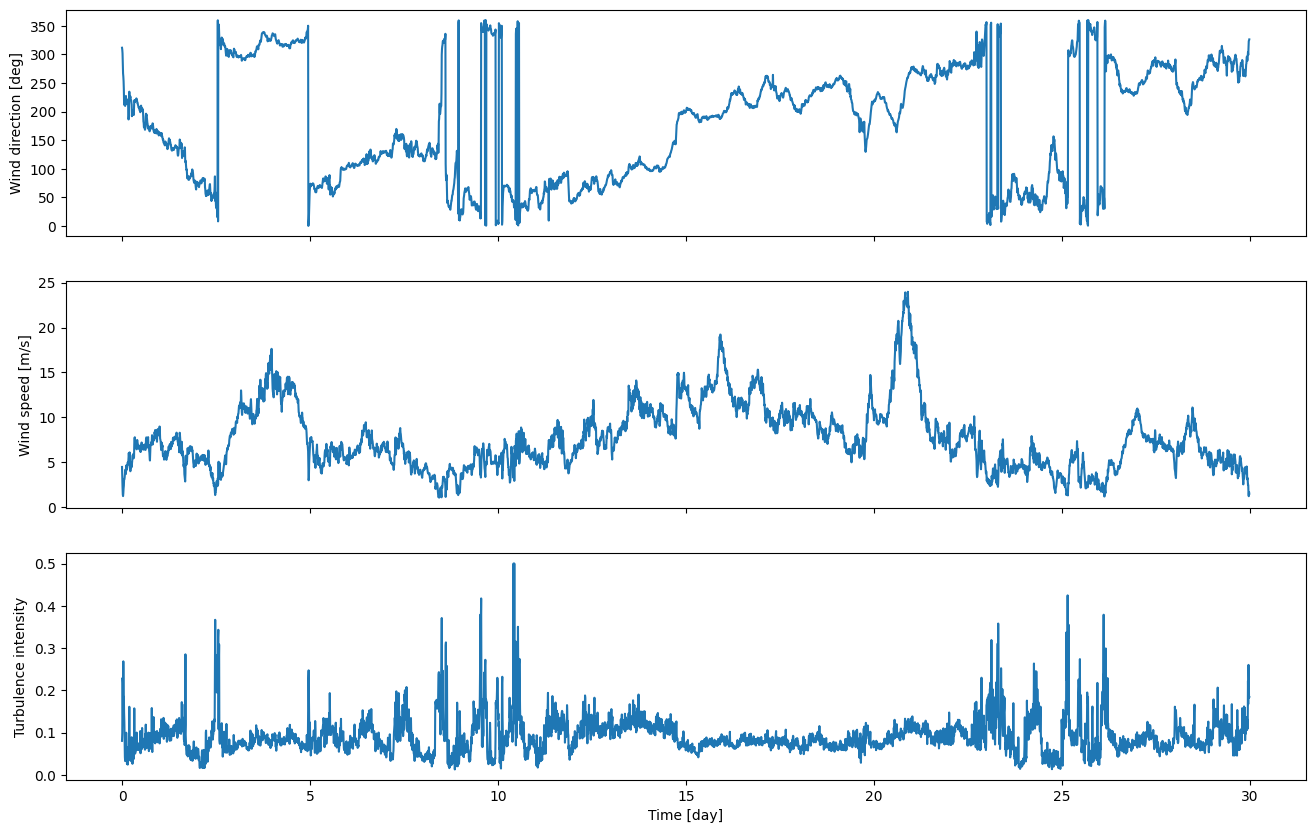

In [13]:
# plot time series
axes = plt.subplots(3,1, sharex=True, figsize=(16,10))[1]

for ax, (v,l) in zip(axes, [(wd, 'Wind direction [deg]'),(ws,'Wind speed [m/s]'),(ti,'Turbulence intensity')]):
    ax.plot(time_stamp, v)
    ax.set_ylabel(l)
_ = ax.set_xlabel('Time [day]')

**Time-dependent wind turbine operation**

Extend the wind turbine with a `operating` setting (0=stopped, 1=normal operation)

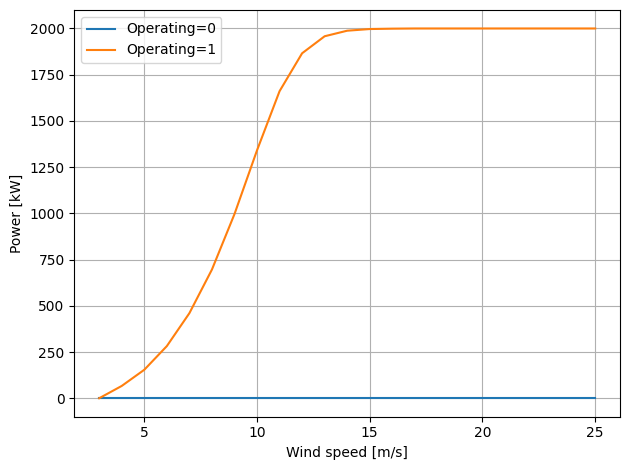

In [14]:
from py_wake.wind_turbines.power_ct_functions import PowerCtFunctionList, PowerCtTabular

# replace powerCtFunction
windTurbines.powerCtFunction = PowerCtFunctionList(
    key='operating',
    powerCtFunction_lst=[PowerCtTabular(ws=[0, 100], power=[0, 0], power_unit='w', ct=[0, 0]), # 0=No power and ct
                         V80().powerCtFunction], # 1=Normal operation
    default_value=1)

# plot power curves
u = np.arange(3,26)
for op in [0,1]:
    plt.plot(u, windTurbines.power(u, operating=op)/1000, label=f'Operating={op}')
setup_plot(xlabel='Wind speed [m/s]', ylabel='Power [kW]')

**Make time-dependent operating variable**

In [15]:
operating = np.ones((len(x), len(time_stamp))) # shape=(#wt, #time stamps)
operating[0,(time_stamp>15)&(time_stamp<20)] = 0 # wt0 not operating from day 5 to 15

Call the wind farm model with the `time=time_stamp` and the time-dependent `operating` keyword argument.

In [16]:
# setup new WindFarmModel with site containing time-dependent TI and run simulation
wf_model = Bastankhah_PorteAgel_2014(site, windTurbines, k=0.0324555)

sim_res_time = wf_model(x, y, # wind turbine positions
                        wd=wd, # Wind direction time series
                        ws=ws, # Wind speed time series
                        time=time_stamp, # time stamps
                        TI=ti, # turbulence intensity time series
                        operating=operating # time dependent operating variable
                  )

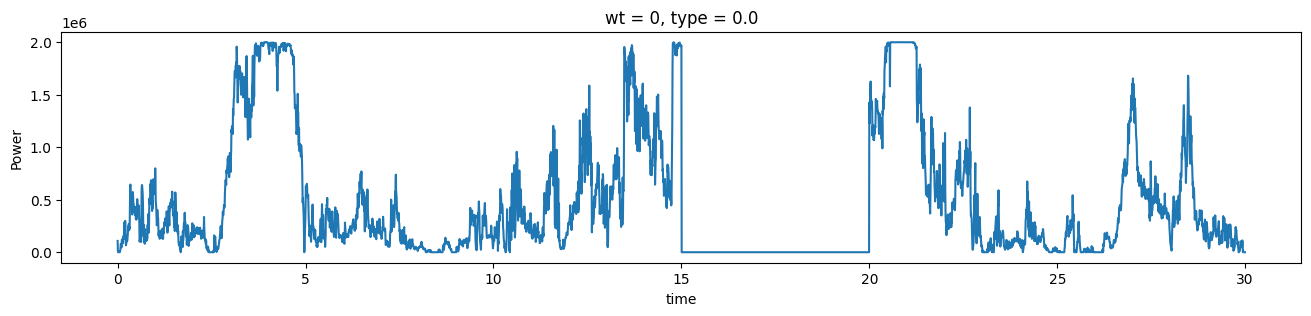

In [17]:
#here we plot the power time series of turbine 0
sim_res_time.Power.sel(wt=0).plot(figsize=(16,3))

In [18]:
sim_res_time.operating

<xarray.DataArray 'operating' (wt: 80, time: 4320)> Size: 3MB
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Coordinates:
  * time     (time) float64 35kB 0.0 0.006944 0.01389 ... 29.98 29.99 29.99
  * wt       (wt) int64 640B 0 1 2 3 4 5 6 7 8 9 ... 71 72 73 74 75 76 77 78 79
    wd       (time) float64 35kB 311.5 308.1 301.7 280.2 ... 323.3 324.4 326.1
    ws       (time) float64 35kB 4.47 3.181 2.215 1.391 ... 1.214 1.692 1.493
    type     (wt) float64 640B 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    Description:

In the no-operating periode time=5..15, the power is 0 as it should be

## Chunkification and Parallelization

PyWake makes it easy to split the wind farm simulation computation into smaller subproblems. This allows:

- Simulation of large wind farms or time series with less memory usage
- Parallel execution for faster simulation

**1) Chunkfication**

To split the simulation into smaller sub-tasks, just specify the desired number of `wd_chunks` and `ws_chunks`.

In [19]:
# split problem into 4x2 subtasks and simulate sequentially on one CPU
sim_res = wf_model(x, y,
                   wd_chunks=4,
                   ws_chunks=2)

Time series of (wd,ws)-flow cases is split into chunks, by specifying either `ws_chunks` or `wd_chunks`

In [20]:
sim_res_time = wf_model(x, y, # wind turbine positions
                        wd=wd, # Wind direction time series
                        ws=ws, # Wind speed time series
                        time=time_stamp, # time stamps
                        wd_chunks=4,
                  )

**Wind speed or wind direction chunks**

In [21]:
%%skip
n_lst = [1,2,4,8,16,23,32]
res = {'ws_chunks': np.array([(n,) + profileit(wf_model)(x, y, wd_chunks=1, ws_chunks=n)[1:] for n in tqdm(n_lst)]),
       'wd_chunks': np.array([(n,) + profileit(wf_model)(x, y, wd_chunks=n, ws_chunks=1)[1:] for n in tqdm(n_lst)])}

ax1,ax2 = plt.subplots(1,2,figsize=(12,4))[1]

for k, d in res.items():
    n,t,m = d.T
    ax1.plot(n,t, label=k)
    ax2.plot(n,m, label=k)
setup_plot(ax=ax1, ylabel='Time [s]', xlabel='Number of chunks')
setup_plot(ax=ax2, ylabel='Memory usage [MB]', xlabel='chunks')
plt.savefig('RunWindFarmSimuation_wdws_chunks.svg')

Cell skipped. Precomputed result shown below. Remove '%%skip' to force run. 


Result computed on the Sophia HPC cluster. Note that the number of wind speed chunks is limited to the number of wind speeds, in this case 23.


It is clearly seen that chunkification of wind directions are more efficient than chunkification of wind speeds with respect to both time and memory usage.

It is also seen that chunkification reduces the memory usage at the cost of computation time. With 32 wind direction chunks, the computational time is more than doubled, i.e. the speedup from running in parallel on a system with 32 CPUs is expected to be less than 16 times.

**2) Parallelization**

Running a wind farm simulation in parallel is just as easy - simply specify the number of CPUs to use to the input argument `n_cpu` or `None` to use all available CPUs.

As seen above, wind directions chunks are more efficient. Hence, the problem is as default split into `n_cpu` wind direction chunks, where `n_cpu` is the numbers of CPUs to use. 

As default, `n_cpu=1` (sequential execution), so to run in parallel, you need to specify a number of CPUs, e.g. `n_cpu=4`. Alternatively, `n_cpu=None` will use all available CPUs.

In [23]:
sim_res = wf_model(x, y,
                   n_cpu=None # run wind directions in parallel on all available CPUs
                  )

**CPU utilization**

The plot below shows the time used to calculate the AEP on 1-32 CPUs as a function of number of wind turbines.

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: 'images/RunWindFarmSimulation_time_cpuwt.svg'

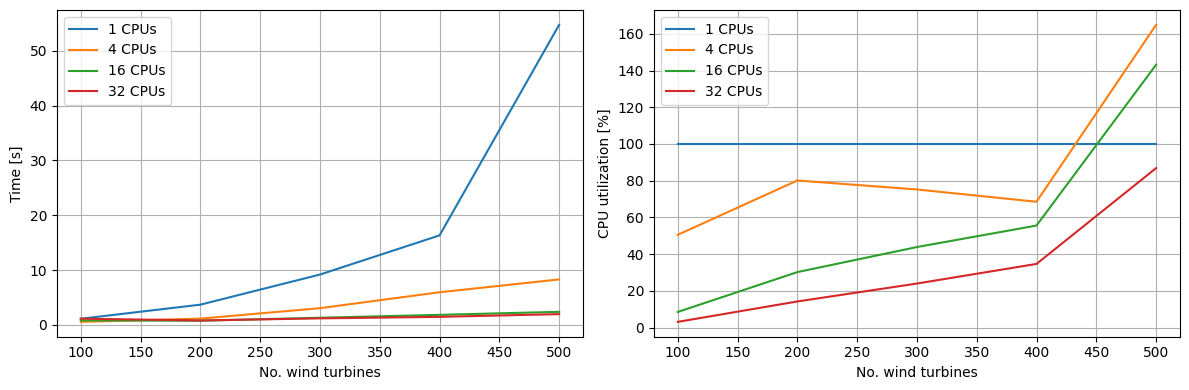

In [ ]:
#%%skip
from py_wake.utils import layouts
from py_wake.utils.profiling import timeit
from tqdm.notebook import tqdm

n_lst = np.arange(100,600,100)

def run(n, n_cpu):
    x,y = layouts.rectangle(n,20,5*windTurbines.diameter())
    return (n, n_cpu, np.mean(timeit(wf_model, min_runs=5)(x,y,n_cpu=n_cpu)[1]))

res = {f'{n_cpu} CPUs': np.array([run(n, n_cpu=n_cpu) for n in tqdm(n_lst)]) for n_cpu in [1, 4, 16, 32]}


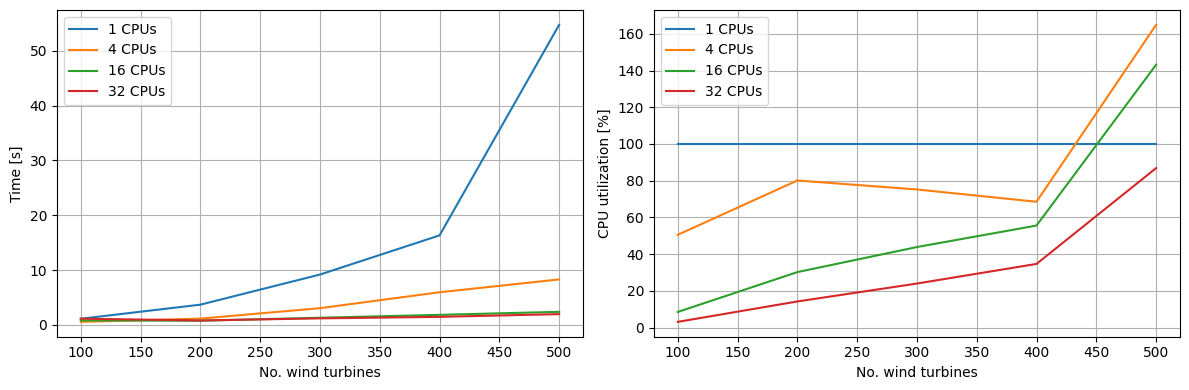

In [26]:
ax1,ax2 = plt.subplots(1,2, figsize=(12,4))[1]
for k,v in res.items():
    n,n_cpu,t = v.T
    ax1.plot(n, t, label=k)
    ax2.plot(n, res['1 CPUs'][:,2]/n_cpu/t*100, label=k)
setup_plot(ax=ax1,xlabel='No. wind turbines',ylabel='Time [s]')
setup_plot(ax=ax2,xlabel='No. wind turbines',ylabel='CPU utilization [%]')
plt.savefig('RunWindFarmSimulation_time_cpuwt.svg')

Result precomputed on the Sophia HPC cluster on a node with 32 CPUs.



The plot clearly shows that the time reduces with more CPUs. In this case, however, the gain from 16 to 32 CPUs is very limited. Note, this may highly dependend on the system architecture.

## Flow map

Finally, `SimulationResult` has a `flow_map` method which returns a `FlowMap` object. This allows the user to visualize the wake behind each turbine's rotor in the wind farm and represents the velocity deficit that occurs due to wake interactions in the wind farm.

In [32]:
from py_wake.examples.data.iea37 import IEA37Site, IEA37_WindTurbines
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014

site = IEA37Site(16)
x, y = site.initial_position.T
windTurbines = IEA37_WindTurbines()

wf_model = Bastankhah_PorteAgel_2014(site, windTurbines, k=0.0324555)
sim_res = wf_model(x,y)

In [33]:
#change the wind speed and wind direction to visualize different flow cases
wsp = 9.8
wdir = 270
flow_map = sim_res.flow_map(grid=None, # defaults to HorizontalGrid(resolution=500, extend=0.2), see below
                            wd=wdir,
                            ws=wsp)

**To plot the wake map we call the plot_wake_map property**.

You can change the values of the wind speed and wind direction to see how different flow maps look like.

Text(0.5, 1.0, 'Wake map for 270 deg and 9.8 m/s')

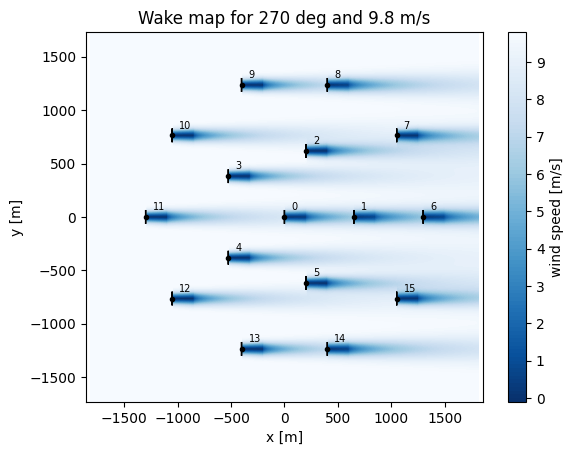

In [34]:
plt.figure()
flow_map.plot_wake_map()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wake map for'+ f' {wdir} deg and {wsp} m/s')

**The wake map can also be customized in terms of size and contour levels.**

Text(0, 0.5, 'y [m]')

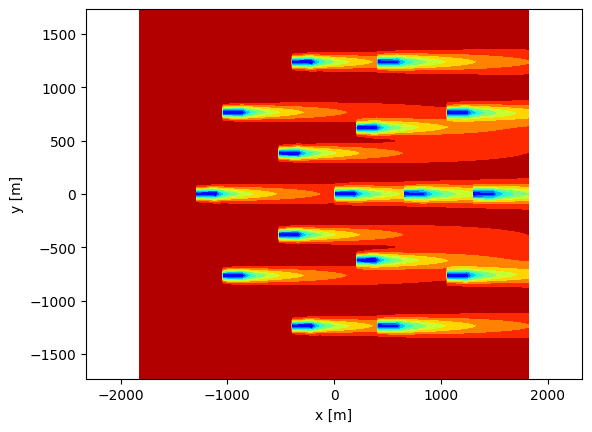

In [35]:
flow_map.plot_wake_map(levels=10, # contourf levels (int or list of levels)
                       cmap='jet', # color map
                       plot_colorbar=False,
                       plot_windturbines=False,
                       ax=None)
plt.axis('equal')
plt.xlabel('x [m]')
plt.ylabel('y [m]')

**There is also a Grid argument that can be set up to further customize the way the flow map is shown in different planes**

The grid argument should be either 

- a `HorizontalGrid`(same as `XYGrid`), `YZGrid` or 
- a tuple(X, Y, x, y, h) where X, Y is the meshgrid for visualizing the data and x, y, h are the flattened grid points

#### HorizontalGrid (XYGrid)

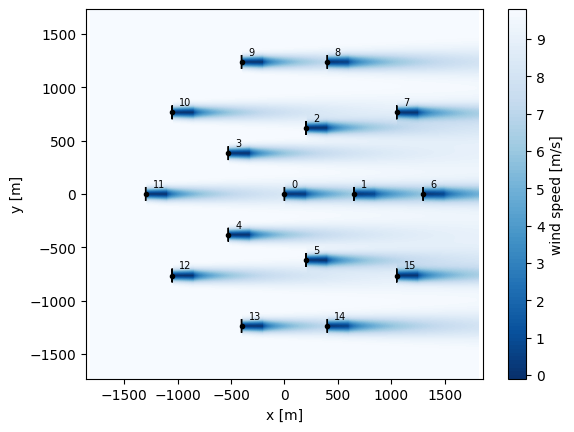

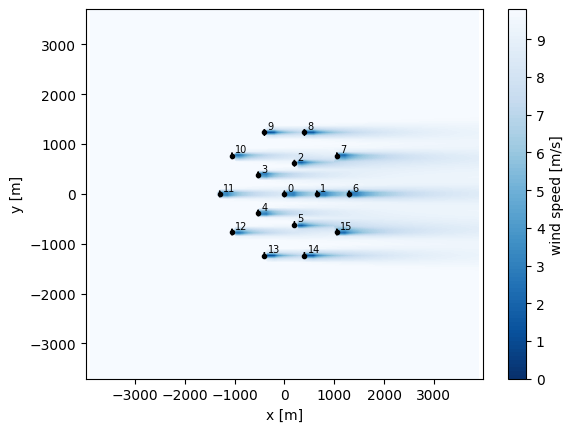

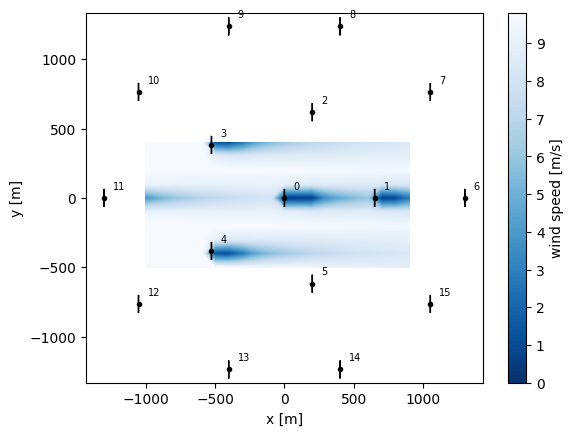

In [36]:
from py_wake import HorizontalGrid

for grid in [None,                                                     # defaults to HorizontalGrid(resolution=500, extend=0.2)
             HorizontalGrid(x=None, y=None, resolution=100, extend=1), # custom resolution and extend
             HorizontalGrid(x = np.arange(-1000,1000,100),
                            y = np.arange(-500,500,100))               # custom x and y
            ]:
    plt.figure()
    sim_res.flow_map(grid=grid, wd=270, ws=[9.8]).plot_wake_map()
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')

#### YZGrid

Plotting the flow map in the vertical YZ plane through the red dashed line can be done using the `YZGrid`

![image3.png](images/RunWindFarmSimulation_yzgrid.png)


Text(0, 0.5, 'z [m]')

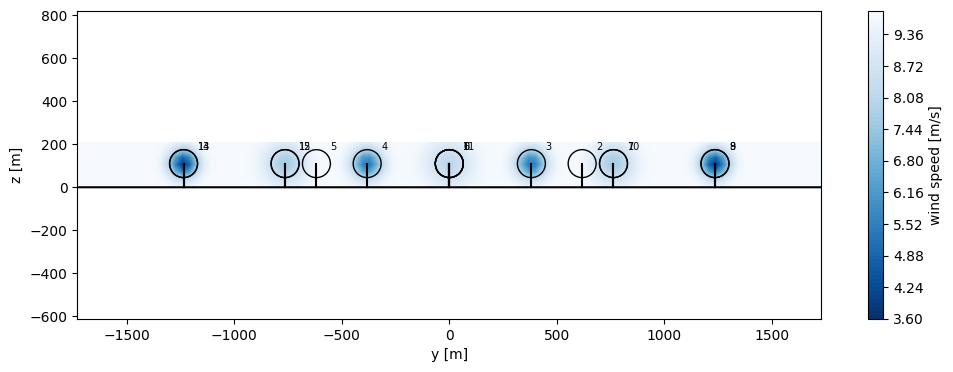

In [37]:
from py_wake import YZGrid
plt.figure(figsize=(12,4))
sim_res.flow_map(YZGrid(x=-100, y=None, resolution=100), wd=270, ws=None).plot_wake_map()
plt.xlabel('y [m]')
plt.ylabel('z [m]')

**3) XZGrid**

Plotting the flow map in the vertical XZ plane through the red dashed line can be done using the `XZGrid`

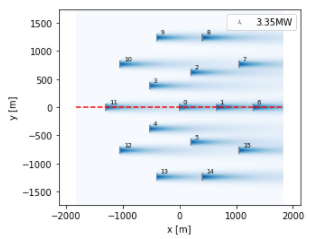


Text(0, 0.5, 'z [m]')

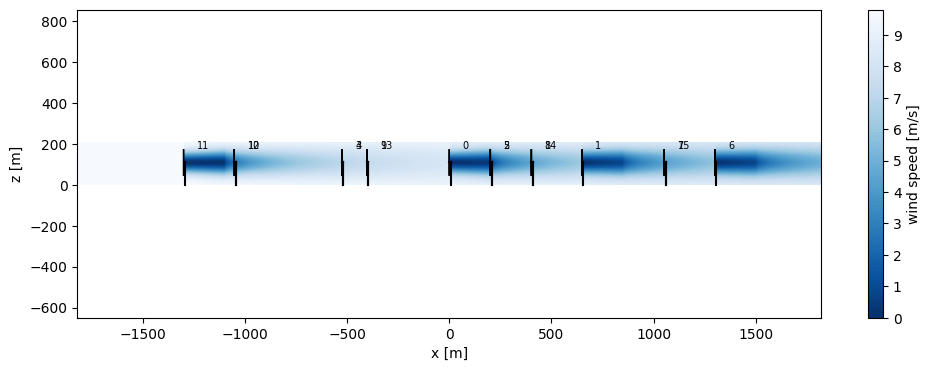

In [38]:
from py_wake import XZGrid
plt.figure(figsize=(12,4))
sim_res.flow_map(grid=XZGrid(y=0, resolution=1000), wd=270, ws=None).plot_wake_map()
plt.xlabel('x [m]')
plt.ylabel('z [m]')